# CS5014 - Machine Learning
## Practical 2 -  Classification of objects using a radar signal and machine learning

In [1]:
#Import libraries
import numpy as np;
import pandas as pd;
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import json
import time


#Test size for split
TEST_SIZE = 0.3

# Load data and assign headers
sensorData = pd.read_csv("binary/X.csv", header=None, names=range(0,768))
classifiedData = pd.read_csv("binary/y.csv", header=None, names="Y")
dataToClassify = pd.read_csv("binary/XToClassify.csv", header=None, names=range(0,768))

with open("binary/key.txt") as file:
    headers = json.load(file)
#Check for null values. Implement cleaning data if there are any.
print(sensorData.isnull().values.any())
print(classifiedData.isnull().values.any())
print(dataToClassify.isnull().values.any())

# #Split the data and ignore test data for the rest of the assignment until testing
train_input, test_input, train_output, test_output  = train_test_split(sensorData, classifiedData, test_size=TEST_SIZE,
random_state=111, stratify=classifiedData)

False
False
False


### 2. Plotting data
In order to understand the data, several plots were generated to find potential patterns. The data was plotted on a sensor by sensor basis and used color coding to identify each classification label available. 
For the case of the binary data it was possible to see that items labelled "book" registered a smaller signal amplitude in comparison to "plastic case".



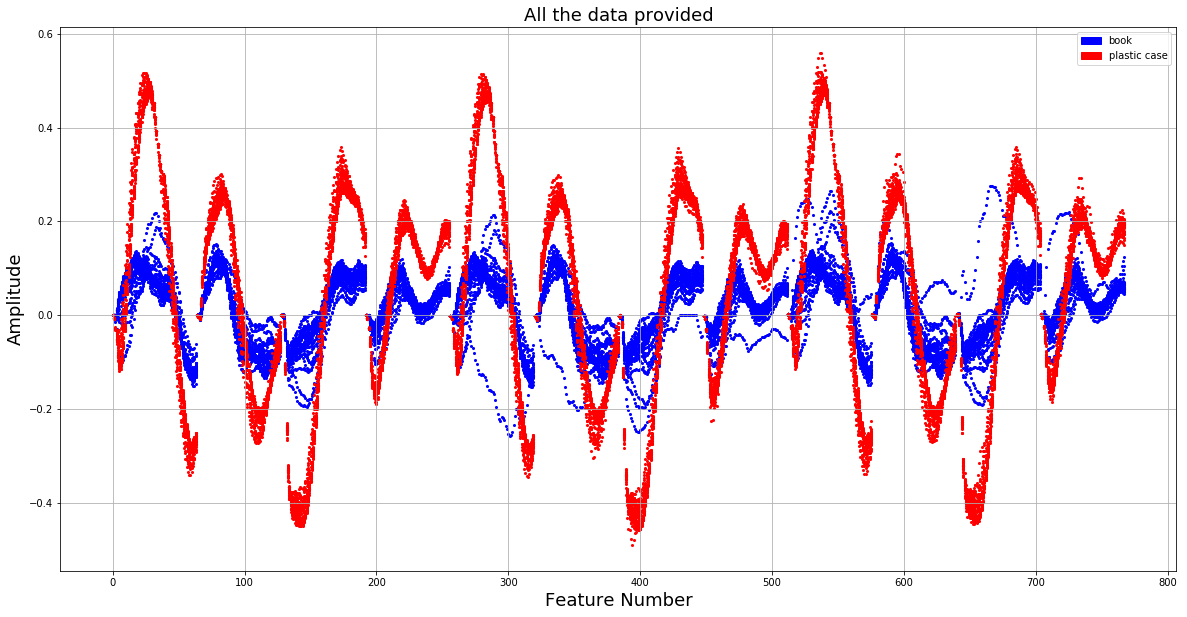

In [2]:
#function to plot by sensor 
def getSensorDataByClassification(inputData, classificationData, classificationLabel):
    index = classificationData.index[classificationData['Y'] == classificationLabel]
    dataset = inputData.loc[index]
    return dataset;

#Create figure and add title
fig= plt.figure(figsize=(20,10))

def plotAllTheData(training_input, output_data, classficationLabel, colour, label):
    # Get all data for a classifcation
    data = getSensorDataByClassification(training_input,output_data,classficationLabel)
    for row in data.values:
        #Plot means, min and max.
        plt.scatter(y=row, x=range(0,768), c=colour, marker='.', linewidths=0.1, label=label)
    plt.title("All the data provided", fontsize=18)
    plt.xlabel("Feature Number", fontsize=18)
    plt.ylabel("Amplitude", fontsize=18)
    plt.grid(True)

        
colours = ['blue','red']
array_of_patches = [];
for classIndex in range(0,len(headers)):
    #Plot all data
    color = colours[classIndex]
    label = headers[str(classIndex)]
    plotAllTheData(train_input,train_output,classIndex,color,label)
    array_of_patches.append(mpatches.Patch(color=color, label=label))

#Add legends and graph information
plt.legend(handles=array_of_patches)
plt.show()

C:\Users\Ricardo\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


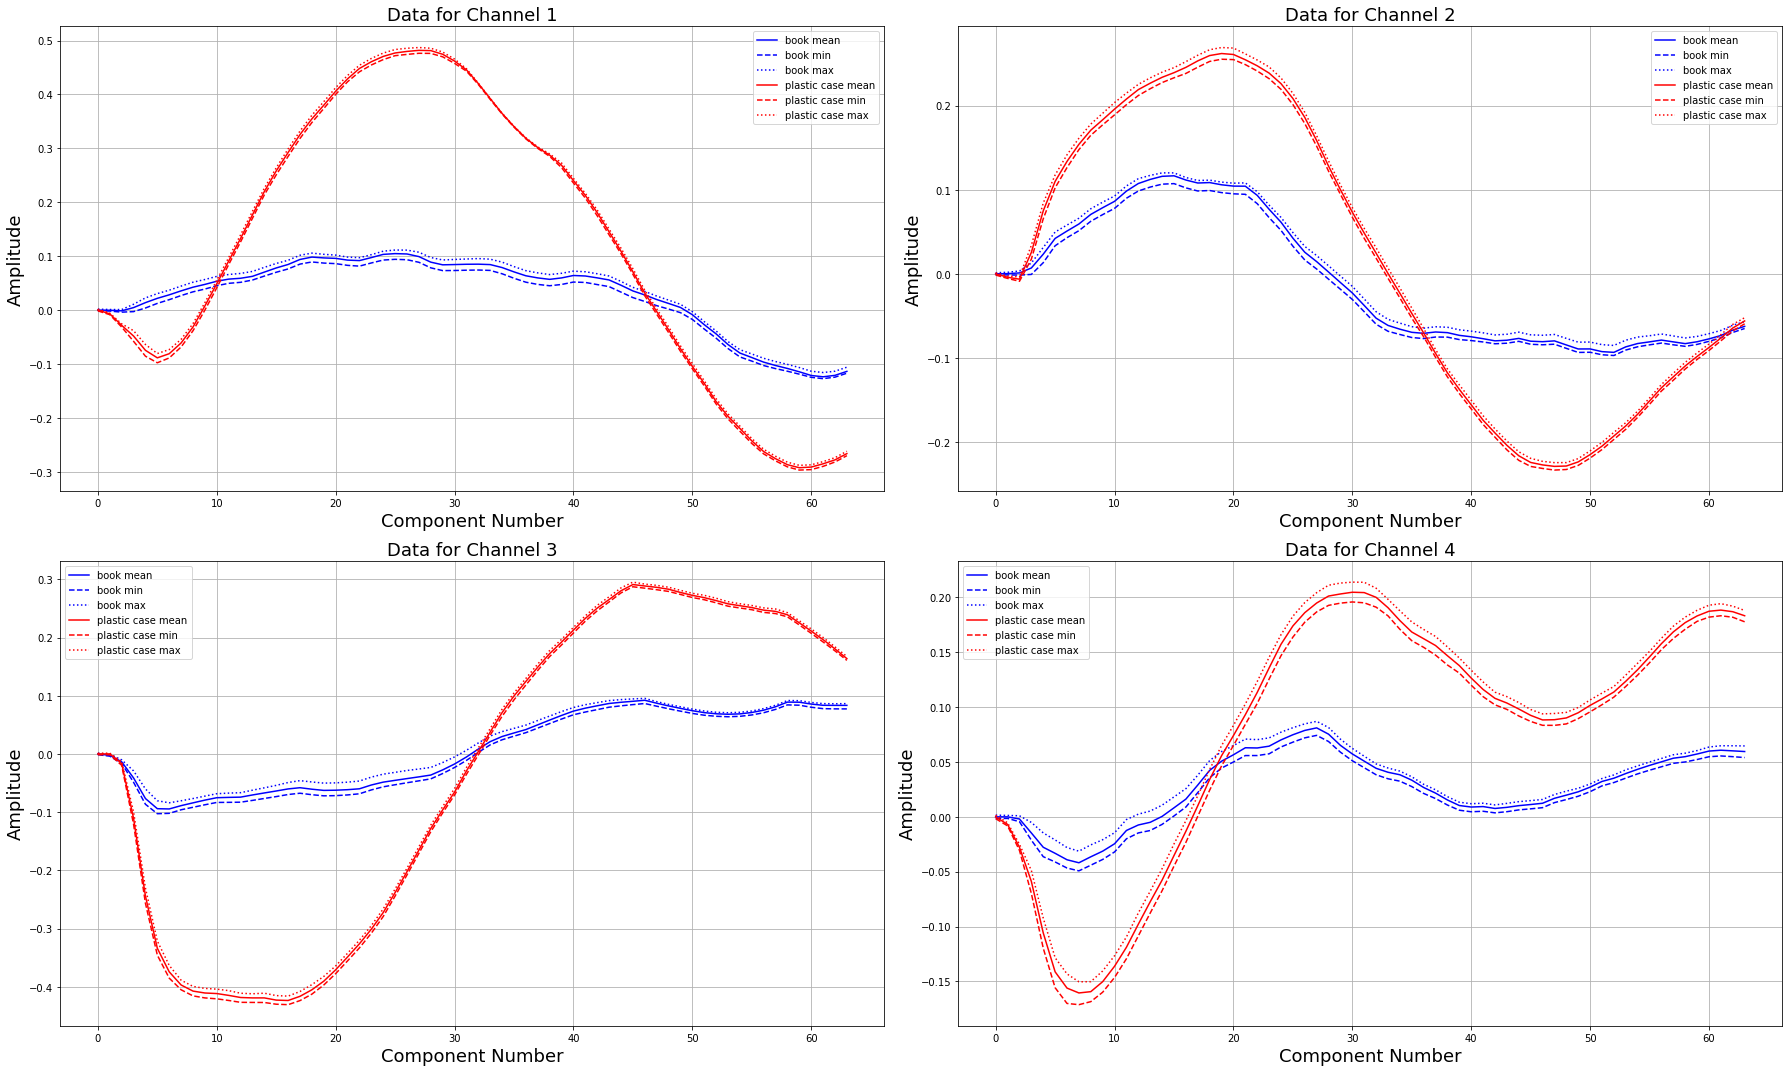

In [3]:
#plot mean average radar signal(summ all the components) and each separate channel together
def plotAveragesData(input_data, output_data, headers, colours):
    fig= plt.figure(figsize=(25,15))
    #Iterate through each class
    for classID in range(0,len(headers)):
        #Get data for each classifcaiton
        classData = getSensorDataByClassification(input_data, train_output, classID)
        #Average accross the feature
        classData = classData.mean(axis = 0)
        colour = colours[classID] 
        #Iterate throguh each channel
        for channelIndex in range(0,4):  
            #Data for channel 1
            ax = plt.subplot(2, 2, channelIndex + 1)
            #mean - get 64
            meanAverageValues = classData[0:256]
            meanAverageValues = meanAverageValues[channelIndex*64:(channelIndex + 1)*64]
            label = headers[str(classID)] + " mean"
            plt.plot(range(0,len(meanAverageValues)), meanAverageValues, label=label, c=colour)

            #min
            minAverageValues = classData[256:512]
            minAverageValues = minAverageValues[channelIndex*64:(channelIndex + 1)*64]
            label = headers[str(classID)] + " min"
            plt.plot(range(0,len(minAverageValues)), minAverageValues, label=label, c=colour ,linestyle='dashed')

            #max
            maxAverageValues = classData[512:768]
            maxAverageValues = maxAverageValues[channelIndex*64:(channelIndex + 1)*64]
            label = headers[str(classID)] + " max"
            plt.plot(range(0,len(maxAverageValues)), maxAverageValues, label=label, c=colour ,linestyle='dotted')
            plt.ylabel("Amplitude", fontsize=18)
            plt.title("Data for Channel " + str(channelIndex + 1), fontsize=18)
            plt.xlabel("Component Number", fontsize=18)
            plt.grid(True)
            plt.legend()
        plt.tight_layout()
            
    plt.show()

plotAveragesData(train_input, train_output,headers,colours)


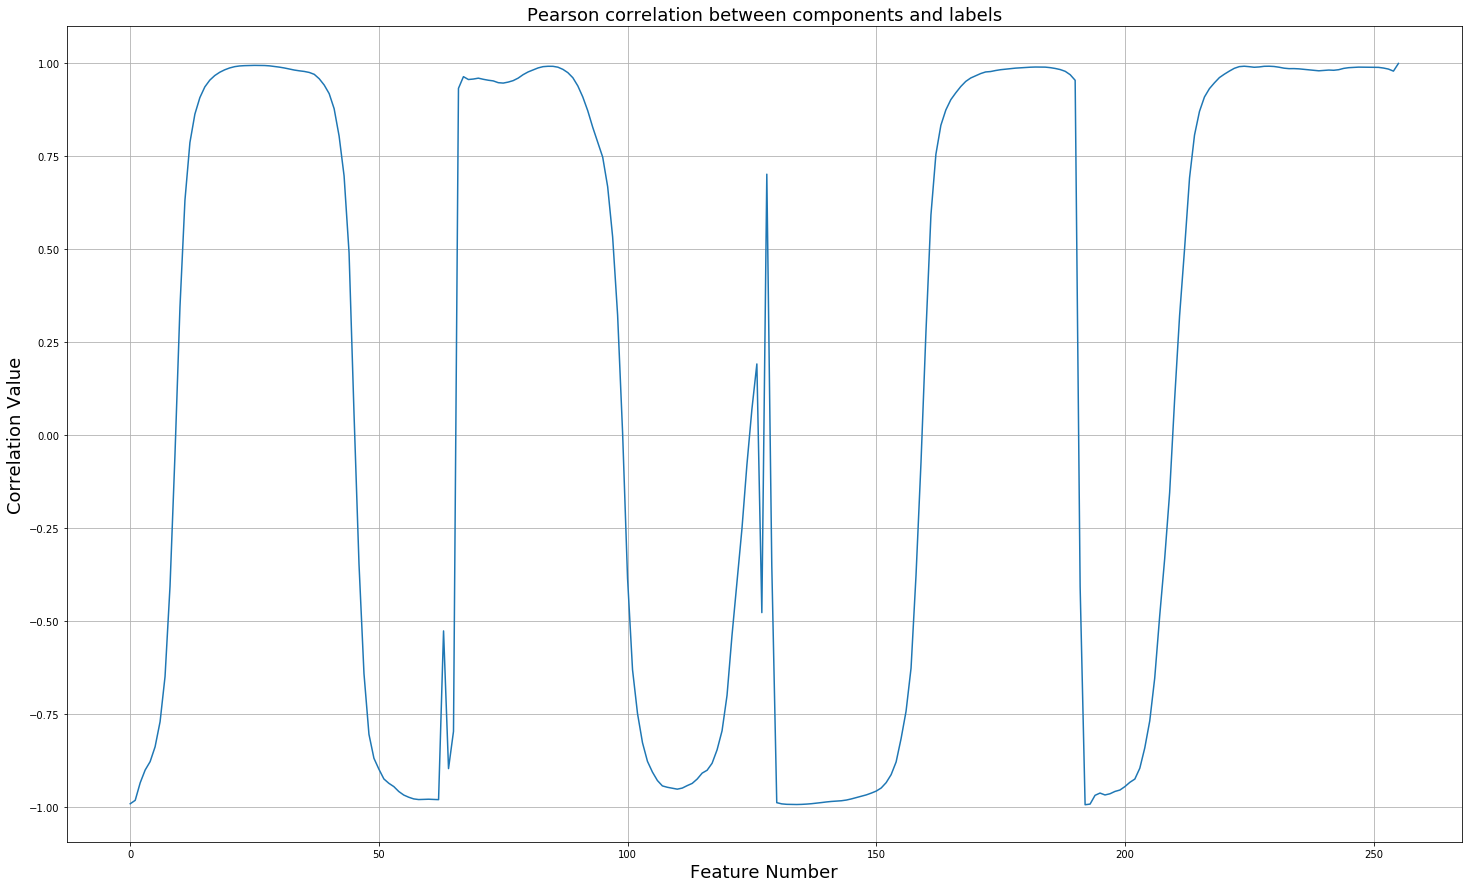

In [4]:
#get correlation of mean to output
def plotMeanCorrelationMatrix(inputData,outputData):
    fig = plt.figure(figsize=(25,15))
    mean_values = train_input.iloc[:,0:256]
    holder_df = mean_values.join(train_output)
    corrMat = holder_df[holder_df.columns[1:]].corr()['Y'][:]
    plt.plot(range(0,len(corrMat)), corrMat)
    plt.ylabel("Correlation Value", fontsize=18)
    plt.title("Pearson correlation between components and labels", fontsize=18)
    plt.xlabel("Feature Number", fontsize=18)
    plt.grid(True)


plotMeanCorrelationMatrix(train_input,train_output)

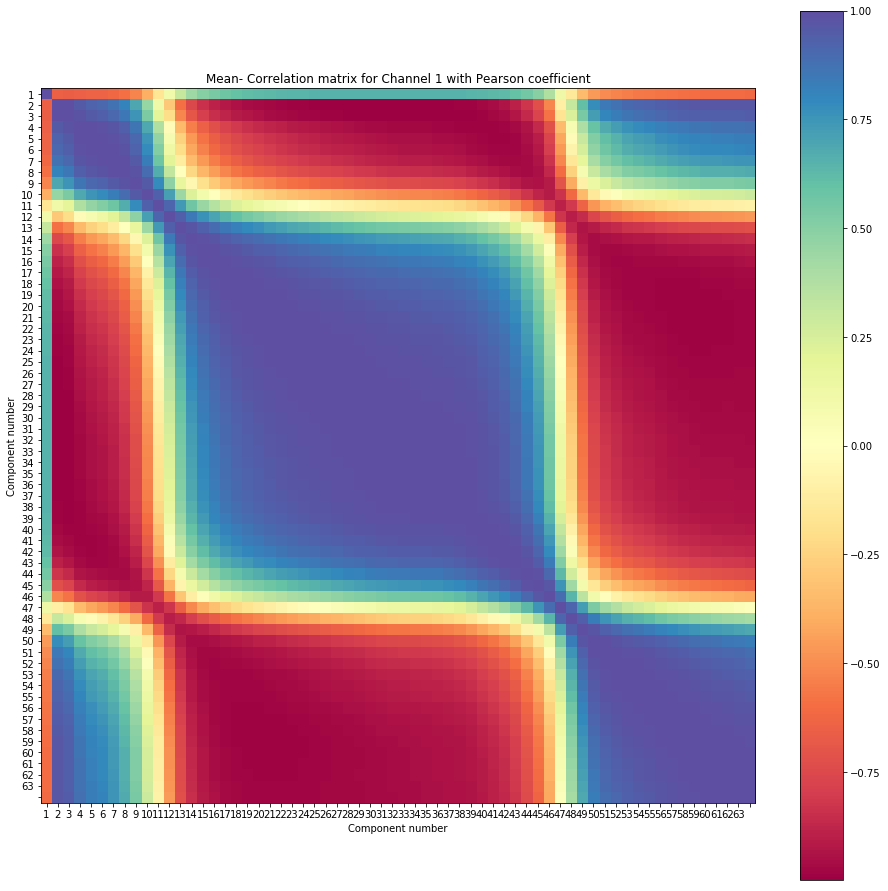

In [5]:
# Create correlation heat map with Pearson Rank Correlation Coefficients for means
corrData = train_input.iloc[:,0:64]
correlationMap = corrData.corr(method='pearson')
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(1,1,1)
#Show correlation matrix and coloar bar.
im = ax.imshow(correlationMap, interpolation='nearest', cmap='Spectral')
ax.figure.colorbar(im, ax=ax)
# Set axis information
ax.set(xticks=np.arange(correlationMap.shape[1]),
               yticks=np.arange(correlationMap.shape[0]),
               xticklabels=range(1,64), yticklabels=range(1,64),
               title="Mean- Correlation matrix for Channel 1 with Pearson coefficient",
               ylabel='Component number',
               xlabel='Component number')
plt.show()

## Principal Component Analysis

Explained variance ratio:
[0.76426139 0.11889084]


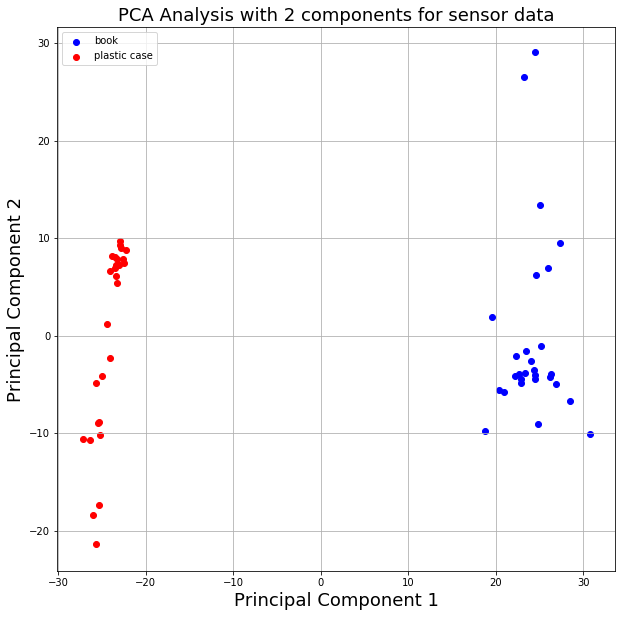

In [6]:
#PCA 2 component analysis.
#Create figure
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1)
#Function calculate PCA
def producePCAData(inputData, classificationData):
     # Create scalar to standardise data and fit data to using it.
    standardisedSensorData = StandardScaler().fit_transform(inputData)
    #set pca to use 2 components
    pca = PCA(n_components=2)
    #Conduct analysis.
    principalComponents = pca.fit_transform(standardisedSensorData)
    #Get the principal dataframe with indices
    principalDf = pd.DataFrame(data = principalComponents, index=classificationData.index
                 , columns = ['PCA1', 'PCA2'])
    #Getting the explained variance ratio for analysis.
    print("Explained variance ratio:")
    print(pca.explained_variance_ratio_)
    return principalDf

#Method to conduct PCA analysis and plot the data
def plotPCAData(principalDf, classificationData,headers, colours):
    #populate with data
    for classIndex in range(0,len(headers)):
        pcaData =  getSensorDataByClassification(principalDf,classificationData,classIndex) 
        plt.scatter(x=pcaData['PCA1'], y=pcaData['PCA2'], linewidths=1, c=colours[classIndex])
    #Setting axes
    plt.xlabel("Principal Component 1", fontsize=18)
    plt.ylabel("Principal Component 2", fontsize=18)
    plt.title("PCA Analysis with 2 components for sensor data", fontsize=18)
    ax.legend(headers.values())
    plt.grid(True)
    plt.show()

#Plot PCA data
pcaData = producePCAData(train_input,train_output)
plotPCAData(pcaData,train_output, headers,colours)

In [7]:
#Train binary model.
def trainSVMBinaryModel(trainingInput, trainingOutput):
    # Create scaler and fit it to training input data
    scaler = StandardScaler().fit(trainingInput)
    # Create a pipeline for Polynomial regression. Add scaler to scale input data.
    pipeline = Pipeline([("scaler", scaler), ("model", svm.SVC(kernel='linear'))])
    # Create regularizatiosn hyperparameter space
    C = [0.01, 0.1, 1, 10]
    # Create hyperparameter options
    hyperparameters = {'model__C':C}
    start = time.time()
    # 10-fold Cross validation
    model = GridSearchCV(estimator=pipeline, param_grid=hyperparameters, cv=10, refit=True, n_jobs=1, scoring='roc_auc', return_train_score=True)
    # fit model to training data
    model.fit(trainingInput.values, trainingOutput.values.ravel())
    end = time.time()
    print("Training Time: " + str(end-start))
    print(model.best_params_)
    # Print the best parameters
    print("Best score: %0.3f" % model.best_score_)
    return model

#Train binary model.
def trainLogisticBinaryModel(trainingInput, trainingOutput):
    # Create scaler and fit it to training input data
    scaler = StandardScaler().fit(trainingInput)
    # Create a pipeline for Polynomial regression. Add scaler to scale input data.
    pipeline = Pipeline([("scaler", scaler), ("model", LogisticRegression())])
    # Create hyperparameter options
    penalty = ['l1'];
    C = [0.01,0.1,1]
    hyperparameters = { "model__penalty":penalty, "model__C":C}
    start = time.time()
    # 10-fold Cross validation
    model = GridSearchCV(estimator=pipeline, param_grid=hyperparameters, cv=10, refit=True, n_jobs=1, scoring='roc_auc',
                        return_train_score=True)
    # fit model to training data
    model.fit(trainingInput.values, trainingOutput.values.ravel())
    end = time.time()
    print("Training Time: " + str(end-start))
    # Print the best parameters
    print(model.best_params_)
    print("Best score: %0.3f" % model.best_score_)
    return model

def testModel(model,test_input,test_output,headers):
    #Check if best_score is sufficient enough to use test data.
    if(model.best_score_ > 0.9):
        start = time.time()
        predictedData = model.predict(test_input)
        end = time.time()
        print("Testing Time: " + str(end-start))
        print(classification_report(y_true=test_output, y_pred=predictedData, target_names=headers.values()))
        #Generate and show confusion matrix
        plotConfusionMatrix(test_output, predictedData, headers)
    else:
        print("The models score is not good enough:")
        
def plotConfusionMatrix(test_output, predictedData, headers):
    confMat = confusion_matrix(test_output.values,predictedData)
#     confMat = confMat.astype('float') / confMat.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(confMat, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(confMat.shape[1]),
               yticks=np.arange(confMat.shape[0]),
               xticklabels=headers, yticklabels=headers,
               title="Confusion matrix",
               ylabel='True label',
               xlabel='Predicted label')
    #Removed from https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
    # Loop over data dimensions and create text annotations.
    for i in range(len(headers)):
        for j in range(len(headers)):
            text = ax.text(j, i, round(confMat[i, j],3), ha="center", va="center")
    plt.show()

C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

Training Time: 0.2740004062652588
{'model__C': 0.1, 'model__penalty': 'l1'}
Best score: 1.000
Testing Time: 0.0
              precision    recall  f1-score   support

        book       1.00      1.00      1.00        12
plastic case       1.00      1.00      1.00        12

   micro avg       1.00      1.00      1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



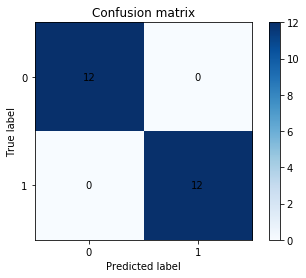

C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

Training Time: 0.15011072158813477
{'model__C': 0.1, 'model__penalty': 'l1'}
Best score: 1.000
Testing Time: 0.0
              precision    recall  f1-score   support

        book       1.00      1.00      1.00        12
plastic case       1.00      1.00      1.00        12

   micro avg       1.00      1.00      1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



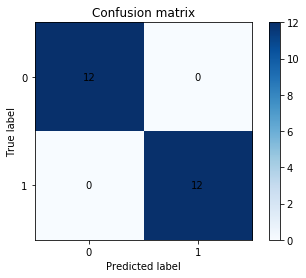

In [8]:
#Only use mean.
train_reduced = train_input.iloc[:,0:256]
test_reduced = test_input.iloc[:,0:256]

#Train and test Logistic Regression Model model
model = trainLogisticBinaryModel(train_input,train_output)
testModel(model,test_input,test_output,headers)

#Train and test Logistic Regression Model model with reduced set
model = trainLogisticBinaryModel(train_reduced,train_output)
testModel(model,test_reduced,test_output,headers)

Training Time: 0.24407720565795898
{'model__C': 0.01}
Best score: 1.000
Testing Time: 0.0
              precision    recall  f1-score   support

        book       1.00      1.00      1.00        12
plastic case       1.00      1.00      1.00        12

   micro avg       1.00      1.00      1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



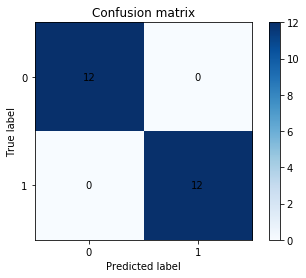

Training Time: 0.15905547142028809
{'model__C': 0.01}
Best score: 1.000
Testing Time: 0.0
              precision    recall  f1-score   support

        book       1.00      1.00      1.00        12
plastic case       1.00      1.00      1.00        12

   micro avg       1.00      1.00      1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



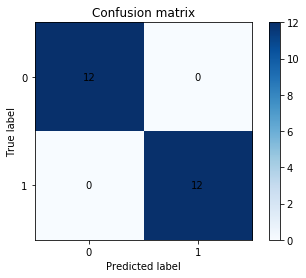

In [9]:
#Only use mean.
train_reduced = train_input.iloc[:,0:256]
test_reduced = test_input.iloc[:,0:256]

#Train and test Support Vector Machine model
model = trainSVMBinaryModel(train_input,train_output)
testModel(model,test_input,test_output,headers)

#Train and test Support Vector Machine model with reduced set
model = trainSVMBinaryModel(train_reduced,train_output)
testModel(model,test_reduced,test_output,headers)

## Retrain model with entire data set

In [10]:
#Retrain model with the entire data set means
train_reduced = sensorData.iloc[:,0:256]
model = trainSVMBinaryModel(train_reduced,classifiedData)

#Classify data for task 
classifiedMeans = dataToClassify.iloc[:,0:256]
predictedUnknownData = model.predict(classifiedMeans)
#Convert predicted data and 
predictedUnknownData = predictedUnknownData.astype(int)
np.savetxt("binaryTask/PredictedClasses.csv", predictedUnknownData, delimiter=",")

Training Time: 0.16438961029052734
{'model__C': 0.01}
Best score: 1.000


In [11]:
# Load data and assign headers
sensorData = pd.read_csv("multiclass/X.csv", header=None, names=range(0,768))
classifiedData = pd.read_csv("multiclass/y.csv", header=None, names="Y")
dataToClassify = pd.read_csv("multiclass/XToClassify.csv", header=None, names=range(0,768))

with open("multiclass/key.txt") as file:
    headers = json.load(file)
    
#Check for null values. Implement cleaning data if there are any.
print(sensorData.isnull().values.any())
print(classifiedData.isnull().values.any())
print(dataToClassify.isnull().values.any())

#Split the data and ignore test data for the rest of the assignment until testing
train_input, test_input, train_output, test_output  = train_test_split(sensorData, classifiedData, test_size=TEST_SIZE,
random_state=111, stratify=classifiedData)

False
False
False


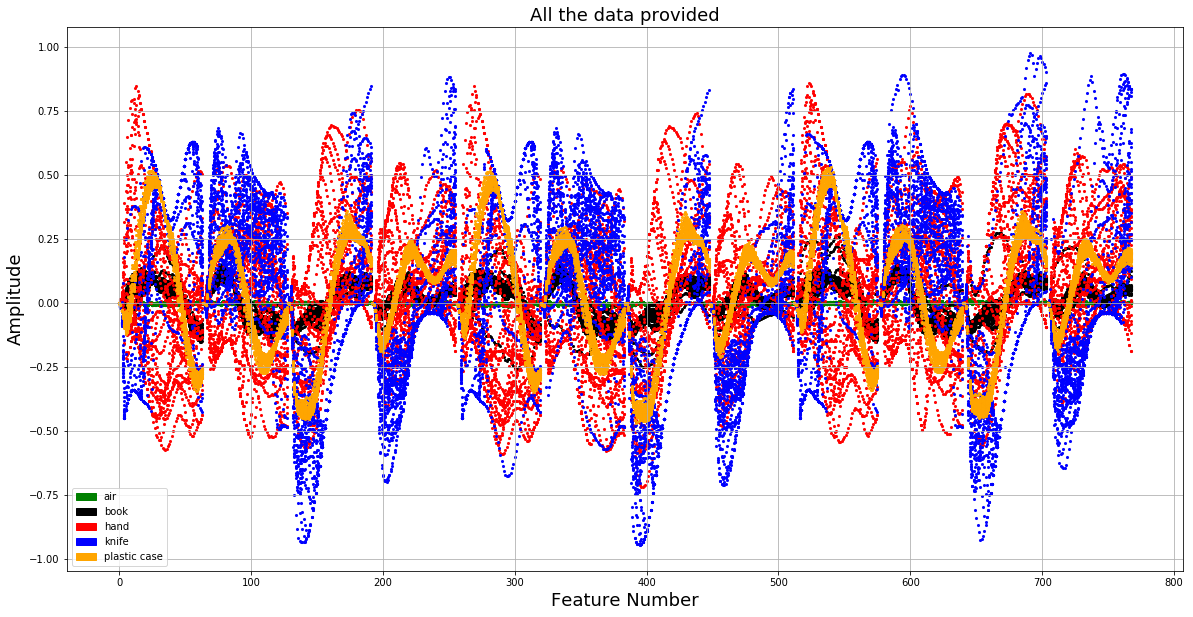

In [12]:
#Plot all the data
fig= plt.figure(figsize=(20,10))
#Generate patches for all data
array_of_patches = [];
colours = ['green','black', 'red', 'blue', 'orange']
for classIndex in range(0,5):
    label = headers[str(classIndex)]
    color = colours[classIndex]
    plotAllTheData(train_input,train_output,classIndex,color,label)
    array_of_patches.append(mpatches.Patch(color=color, label=label))
    
#Add legends and graph information
plt.legend(handles=array_of_patches)
plt.show()

C:\Users\Ricardo\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


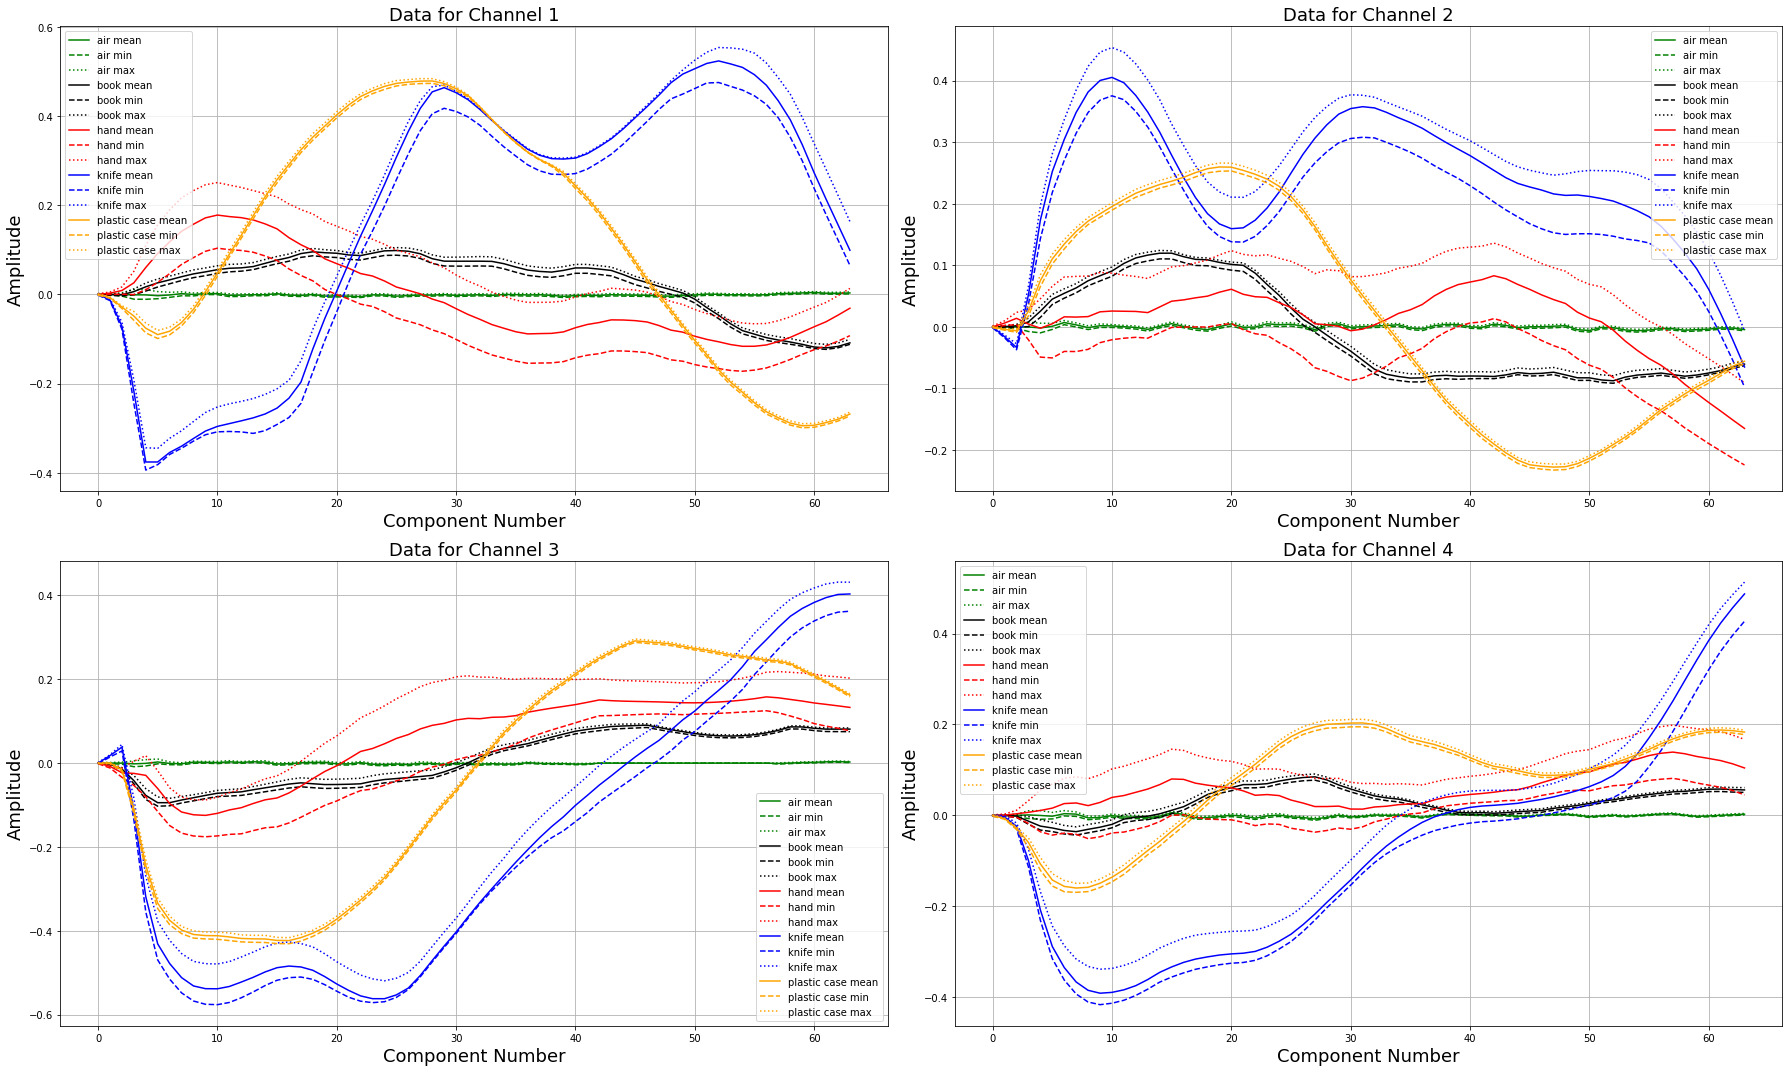

In [13]:
plotAveragesData(train_input, train_output,headers,colours)

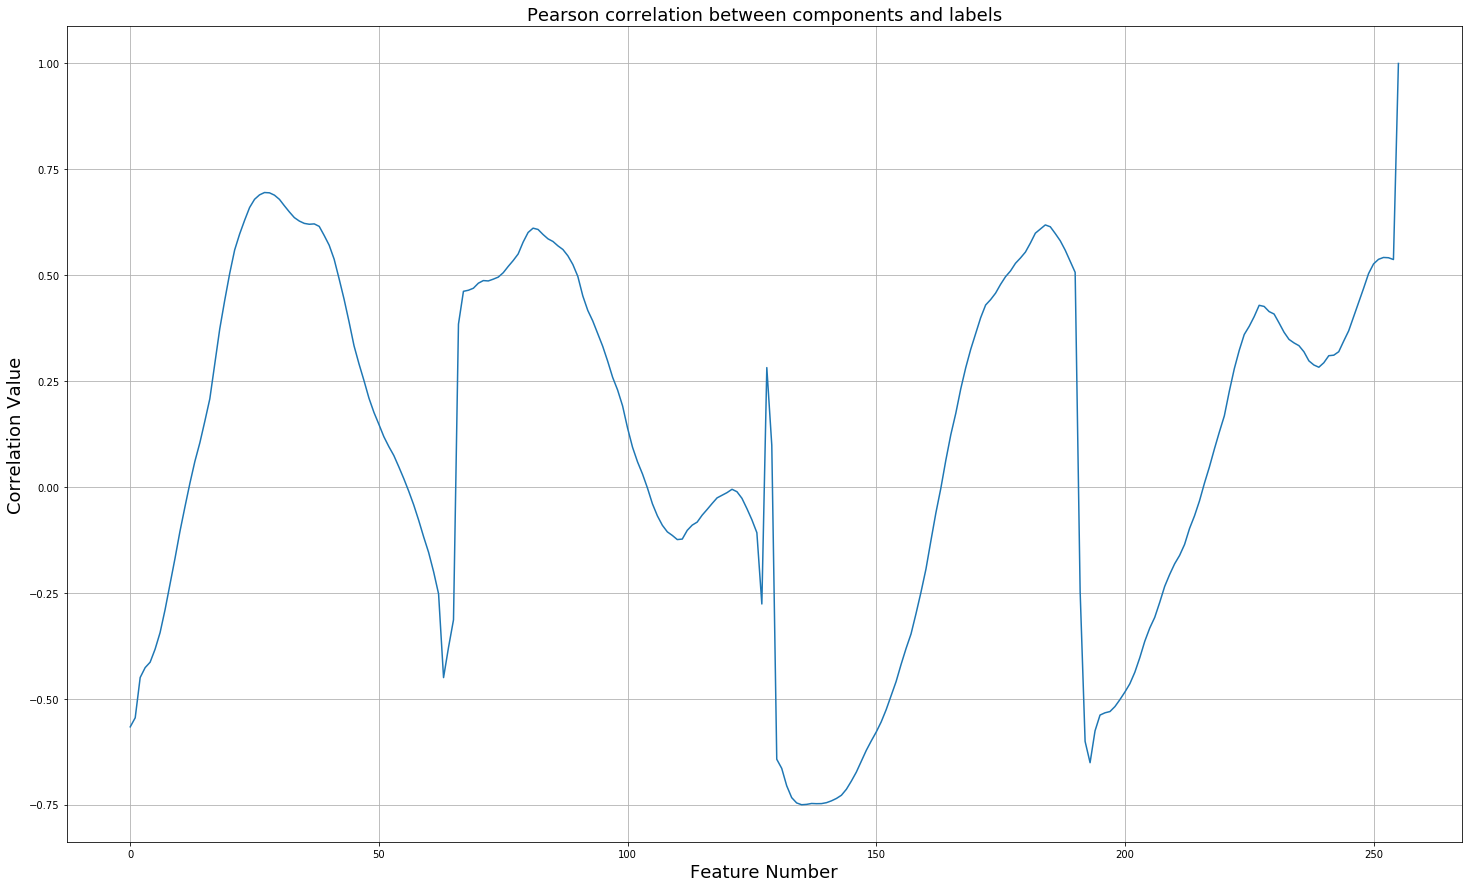

In [14]:
plotMeanCorrelationMatrix(train_input,train_output)

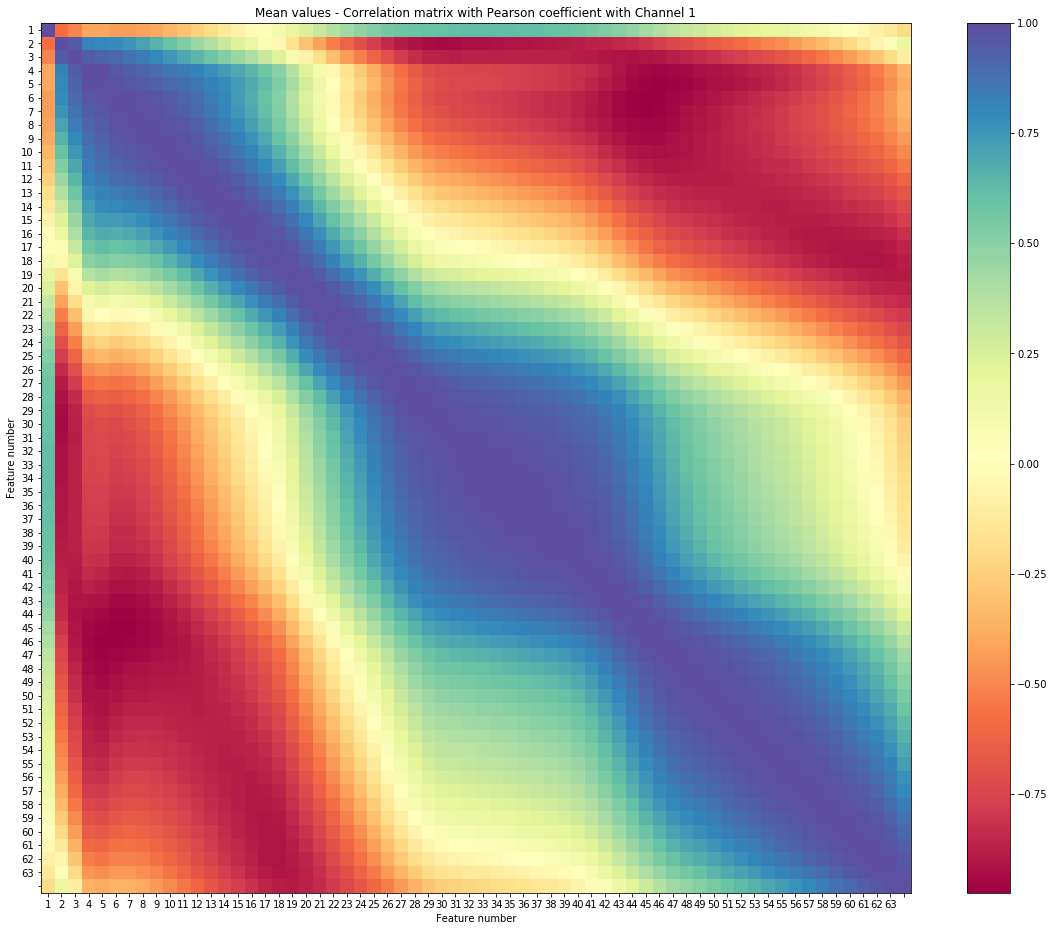

In [15]:
# Create correlation heat map with Pearson Rank Correlation Coefficients for means
corrData = train_input.iloc[:,0:64]
correlationMap = corrData.corr(method='pearson')
fig = plt.figure(figsize = (20,16))
ax = fig.add_subplot(1,1,1)
#Show correlation matrix and coloar bar.
im = ax.imshow(correlationMap, interpolation='nearest', cmap='Spectral')
ax.figure.colorbar(im, ax=ax)
# Set axis information
ax.set(xticks=np.arange(correlationMap.shape[1]),
               yticks=np.arange(correlationMap.shape[0]),
               xticklabels=range(1,64), yticklabels=range(1,64),
               title="Mean values - Correlation matrix with Pearson coefficient with Channel 1",
               ylabel='Feature number',
               xlabel='Feature number')
plt.show()

Explained variance ratio:
[0.43489879 0.29062365]


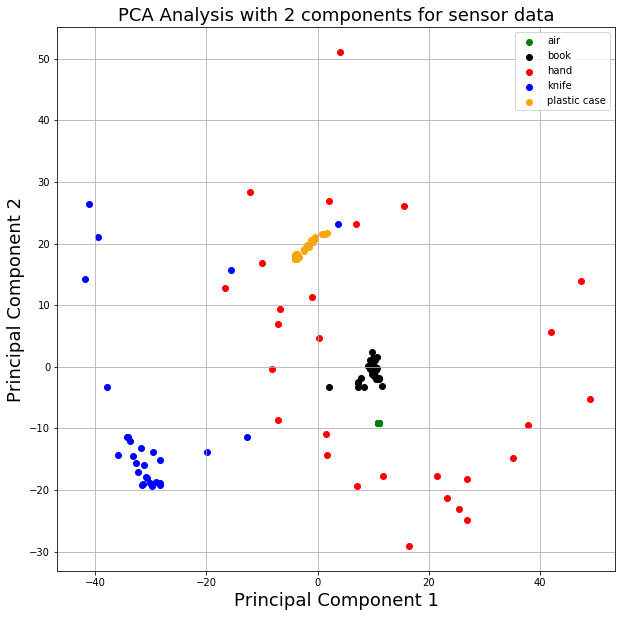

In [16]:
#PCA 2 component analysis.
#Create figure
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1)
#Plot PCA data
pcaData = producePCAData(train_input,train_output)
plotPCAData(pcaData,train_output, headers,colours)

In [17]:
#Train svm for multiclass model.
def trainSVMMultiClassModel(trainingInput, trainingOutput):
    # Create scaler and fit it to training input data
    scaler = StandardScaler().fit(trainingInput)
    # Create a pipeline for support vector machine with poly kernel . Add scaler to scale input data.
    pipeline = Pipeline([("scaler", scaler), ("model", svm.SVC(kernel='poly', decision_function_shape ='ovr'))])
    # Create regularizatiosn hyperparameter space
    C = [0.01, 0.1, 1, 10]
    gamma =[0.1,1]
    degree=range(1,4)
     # Create hyperparameter options
    hyperparameters = {'model__C':C, 'model__gamma':gamma, 'model__degree':degree}
    # 10-fold Cross validation
    start = time.time()
    model = GridSearchCV(estimator=pipeline, param_grid=hyperparameters, cv=10, refit=True, n_jobs=1, scoring='f1_micro',
                         return_train_score=True)
    # fit model to training data
    model.fit(trainingInput.values, trainingOutput.values.ravel())
    end = time.time()
    print("Training Time: " + str(end-start))
    print(model.best_params_)
    # Print the best parameters
    print("Best score: %0.3f" % model.best_score_)
    return model

#Train Logistic model.
def trainLogisticMulticlassModel(trainingInput, trainingOutput):
    # Create scaler and fit it to training input data
    scaler = StandardScaler().fit(trainingInput)
    # Create a pipeline for Polynomial regression. Add scaler to scale input data.
    pipeline = Pipeline([("scaler", scaler), ("model", LogisticRegression(multi_class='multinomial',solver='lbfgs'))])
    # Create hyperparameter options
    penalty = ['l2'];
    C = [0.01, 0.1, 1]
    hyperparameters = { "model__penalty":penalty,'model__C':C}
    start = time.time()
    # 10-fold Cross validation
    model = GridSearchCV(estimator=pipeline, param_grid=hyperparameters, cv=10, refit=True, n_jobs=1, scoring='f1_micro',
                        return_train_score=True)
    
    # fit model to training data
    model.fit(trainingInput.values, trainingOutput.values.ravel())
    end = time.time()
    print("Training Time: " + str(end-start))
    # Print the best parameters
    print(model.best_params_)
    print("Best score: %0.3f" % model.best_score_)
    return model

C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Training Time: 4.589868068695068
{'model__C': 0.01, 'model__degree': 1, 'model__gamma': 1}
Best score: 0.950
Testing Time: 0.0
              precision    recall  f1-score   support

         air       1.00      1.00      1.00        12
        book       0.86      1.00      0.92        12
        hand       1.00      0.83      0.91        12
       knife       1.00      1.00      1.00        12
plastic case       1.00      1.00      1.00        12

   micro avg       0.97      0.97      0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



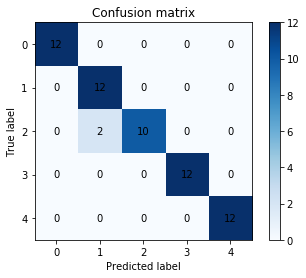

C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Training Time: 4.100619792938232
{'model__C': 0.01, 'model__degree': 1, 'model__gamma': 1}
Best score: 0.950
Testing Time: 0.008183002471923828
              precision    recall  f1-score   support

         air       1.00      1.00      1.00        12
        book       0.86      1.00      0.92        12
        hand       0.91      0.83      0.87        12
       knife       1.00      0.92      0.96        12
plastic case       1.00      1.00      1.00        12

   micro avg       0.95      0.95      0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



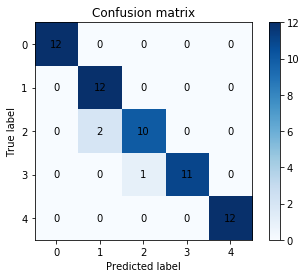

In [18]:
#Only use mean.
train_reduced = train_input.iloc[:,0:512]
test_reduced = test_input.iloc[:,0:512]

#Train and test SVM Regression Model model
model = trainSVMMultiClassModel(train_input,train_output)
testModel(model,test_input,test_output,headers)

#Train and test SVM with smaller set
model = trainSVMMultiClassModel(train_reduced,train_output)
testModel(model,test_reduced,test_output,headers)

C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", 

Training Time: 8.139710903167725
{'model__C': 0.1, 'model__penalty': 'l2'}
Best score: 0.964
Testing Time: 0.003522634506225586
              precision    recall  f1-score   support

         air       0.92      1.00      0.96        12
        book       0.86      1.00      0.92        12
        hand       1.00      0.75      0.86        12
       knife       1.00      1.00      1.00        12
plastic case       1.00      1.00      1.00        12

   micro avg       0.95      0.95      0.95        60
   macro avg       0.96      0.95      0.95        60
weighted avg       0.96      0.95      0.95        60



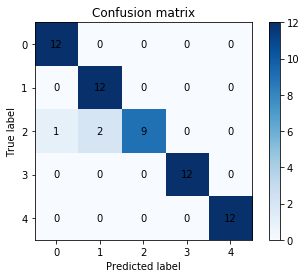

C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", 

Training Time: 3.789792060852051
{'model__C': 0.1, 'model__penalty': 'l2'}
Best score: 0.957
Testing Time: 0.0
              precision    recall  f1-score   support

         air       0.92      1.00      0.96        12
        book       0.86      1.00      0.92        12
        hand       1.00      0.75      0.86        12
       knife       1.00      1.00      1.00        12
plastic case       1.00      1.00      1.00        12

   micro avg       0.95      0.95      0.95        60
   macro avg       0.96      0.95      0.95        60
weighted avg       0.96      0.95      0.95        60



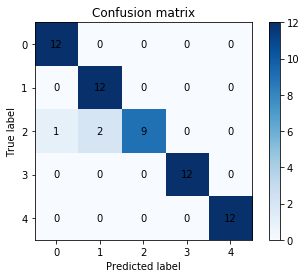

In [19]:
#Train and test Logistic Regression Model model
model = trainLogisticMulticlassModel(train_input,train_output)
testModel(model,test_input,test_output,headers)

#Train and test Logistic Regression Model model
model = trainLogisticMulticlassModel(train_reduced,train_output)
testModel(model,test_reduced,test_output,headers)

In [20]:
#Retrain model with the entire data set
model = trainSVMMultiClassModel(sensorData,classifiedData)

#Classify data for task 
predictedUnknownData = model.predict(dataToClassify)
#Convert predicted data and 
predictedUnknownData = predictedUnknownData.astype(int)
np.savetxt("multiClassTask/PredictedClasses.csv", predictedUnknownData, delimiter=",")

Training Time: 10.24999475479126
{'model__C': 0.1, 'model__degree': 1, 'model__gamma': 1}
Best score: 0.960
